## Background / Motivation

The analytics revolution in sports started meekly in 2001. An impoverished Oakland A’s organization realized they were at a serious financial disadvantage compared to big teams like the New York Yankees and Los Angeles Dodgers. They tried to use analytics and simple statistical theory to extract value from cheap players that had been deemed worthless by the rest of the league. The push was a success. That year the A’s won the pennant before eventually falling in the ALDS despite being at such a financial disadvantage. 

By 2013, Big Data had become a mainstay in professional sports. The MLB tracks everything from Pitch Speed, to Launch Angle, to time from home plate to first base. Players that were once measured by height and weight now are categorized by hundreds of thousands of numbers. Analytics sites like KenPom and NETRATINGS have popped up alongside the Big Data boom in sports to glean insights to help teams win games.

## Problem statement

Given a dataset that tracked every MLB pitch in the 2019 season, I tried to find useful predictors that could make a successful classification model. The predictors included attributes such as Start Speed, Plate Position, Break Angle, and the given count in which a pitch was thrown. It also gave outcomes, which I classified as either successful or unsuccessful for a pitcher based on whether or not the outcome was desirable.

It's important to note that in all sports, there is a human element that can not be accounted for by any model. Humans are not machines that can be perfectly predicted by a subset of variables. The best athletes in the world will come close after decades of perfecting their craft in an attempt to produce identical results, but there will still be nights where the best pitcher in the world cannot throw a strike.

## Data sources

I used an MLB dataset from [Kaggle](https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018?resource=download), which included data on every pitch from 2015-2019. I opted to only use the 2019  data since the size of the data was so large. The data gives many advanced metrics about the pitch and the game situation when the pitch was thrown, giving plenty variables to explore that could affect the outcomes.

## Stakeholders

There are many different stakeholders, as there are many levels to a baseball organization. First and foremost, pitchers have a lot to gain from these results. Pitching in baseball is an artform, and there are many ways to be effective. No two pitchers have the same delivery, same pitch mix, or same pitching style. However, one thing all successful pitchers share is their ability to throw strikes. If these results shed light on a certain attribute of a pitch that leads to a higher rate of strikes, pitchers who have done all they can to get an edge up on the competition from a physcial standpoint should be inclined to change their strategy to increase strike rate and therefore increase pitching performance. While there are obviously plenty of other factors in a pitching matchup that this dataset doesn't account for, for example the hitter, this could be a good starting point to give general advice for pitchers struggling to throw strikes.

Another group with potential interest in these results are MLB coaches. While the idea of classification at the time of the pitch will not be useful for in-game adjustments since a pitch must be thrown before predicting whether or not it will be a strike, it can still be useful information for a coach to have and apply to every pitcher on their roster. While an individual pitcher may experience success from changing a thing or two about their pitching style based on our results, a coach could see an exponential increase in pitching performance if they applied that newfound knowledge to their whole pitching staff.

The last and arguably most important stakeholder in these results are baseball scouts and analysts. While in-game adjustments based on these results are not possible, the results could allow a scout or analyst to locate potential star pitchers based on their pitches performance in the model. While throwing strikes does not guarantee success at the next level, there has also never been a successful pitcher that cannot throw strikes. This could help scouts identify players whose potential does not match the results on the field. If a pitcher is physically underdeveloped but has the attributes the model suggests are important for throwing strikes or is phyiscally gifted but could improve based on the attributes of the model, a scout could recommend a team picks or drafts a pitcher and give a concrete plan on how that pitcher can improve. 

## Data quality check / cleaning / preparation 

### Data check


In [26]:
# Importing libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Reading data
pitch_data = pd.read_csv('2019_pitches.csv')

# Randomly sampling 10,000 entries for train data and 2,000 for test data w/o replacement
np.random.seed(54321)
train = pitch_data.sample(n = 10000, replace = False)
pitch_data = pitch_data.drop(train.index)
test = pitch_data.sample(n = 2000, replace = False)

# Helper function to evaluate model quality
def confusion_matrix_data(data, actual_values, model, cutoff=.5):
    pred_values = model.predict(data)
    # Specify the bins
    bins = np.array([0,cutoff,1])
    # Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0] + cm[1,1])
    fpr = (cm[0,1])/(cm[0,0] + cm[0,1])
    precision = (cm[1,1])/(cm[1,1] + cm[0,1])
    tpr = (cm[1,1])/(cm[1,0] + cm[1,1]) # Recall
    
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))

In [27]:
# Continuous variables
train.describe()

,px,pz,start_speed,end_speed,break_angle,break_length,break_y,ax,ay,az,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.0,9912.000000,9912.000000,9912.000000,...,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.0,10000.0,10000.0
mean,0.031429,2.228608,88.663620,81.715466,20.258838,6.603269,24.0,-2.498676,25.584722,-23.521181,...,259.385100,2.444400,2.019093e+09,0.826500,0.17490,0.978900,2.915700,0.0,0.0,0.0
std,0.855776,0.960891,5.906996,5.300395,12.543700,2.842693,0.0,10.320402,3.707176,8.692776,...,156.511659,2.699859,5.319448e+04,0.934497,0.41896,0.818487,1.753654,0.0,0.0,0.0
min,-3.130000,-3.580000,53.600000,49.700000,0.000000,2.400000,24.0,-26.730000,9.270000,-49.670000,...,5.000000,0.000000,2.019000e+09,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.0
25%,-0.560000,1.610000,84.500000,78.100000,8.400000,4.800000,24.0,-11.272500,22.760000,-29.520000,...,127.000000,0.000000,2.019047e+09,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.0
50%,0.020000,2.230000,89.700000,82.600000,20.400000,6.000000,24.0,-2.690000,25.570000,-22.730000,...,253.000000,2.000000,2.019093e+09,1.000000,0.00000,1.000000,3.000000,0.0,0.0,0.0
75%,0.600000,2.860000,93.400000,85.900000,30.000000,8.400000,24.0,5.352500,28.340000,-16.177500,...,381.000000,4.000000,2.019139e+09,1.000000,0.00000,2.000000,4.000000,0.0,0.0,0.0
max,4.380000,8.450000,101.900000,93.700000,61.200000,18.000000,24.0,28.220000,39.110000,-5.040000,...,979.000000,18.000000,2.019185e+09,3.000000,2.00000,2.000000,13.000000,0.0,0.0,0.0


In [59]:
table_rows = []
for var in train.columns:
    # Check if the variable is categorical or continuous
    if train[var].dtype == 'object':
        missing_values = train[var].isnull().sum()
        unique_values = train[var].nunique()
        table_rows.append([var, 'Categorical', missing_values, unique_values])
    else:
        # If continuous, calculate the summary statistics
        desc = train[var].describe()
        missing_values = train[var].isnull().sum()
        unique_values = '-'
        table_rows.append([var, 'Continuous', missing_values, unique_values])

# Create a DataFrame from the table rows
table_df = pd.DataFrame(table_rows, columns=['Variable', 'Type', 'Missing Values', 'Unique Values'])

# Print the table
table_df

,Variable,Type,Missing Values,Unique Values
0,px,Continuous,88,-
1,pz,Continuous,88,-
2,start_speed,Continuous,88,-
3,end_speed,Continuous,88,-
4,spin_rate,Categorical,88,1
5,spin_dir,Categorical,88,1
6,break_angle,Continuous,88,-
7,break_length,Continuous,88,-
8,break_y,Continuous,88,-
9,ax,Continuous,88,-


### Data cleaning/preparation

- Based on the Pitch Code definitions that came straight from [Kaggle](https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018?resource=download), I classified results that I considered a pitcher success as 1, a pitcher failure as 0, and dropped the few results that were neither a success nor failure by the pitcher, because they involved the actions of other players.
- Also dropped all of the columns containing data that should have no impact on play result, leaving `start_speed`, `break_angle`, `break_length`, `code`, `pitch_type`, `b_count`, `s_count`, `outs`, `Result`, `px`, and `pz`.

In [14]:
# Classifying results as 1=pitcher success over batter (i.e. strike) and 0=pitcher failure over batter (i.e. ball)
train = train[-train['code'].isin(['X','D','E'])]
train['Result'] = train['code'].map({'S':1, 'C':1, 'F':1, 'T':1,'L':1, 'W':1, 'M':1, 'Q':1, 'R':1, 'B':0, '*B':0, 'I':0, 'P':0, 'H':0})

test = test[-test['code'].isin(['X','D','E'])]
test['Result'] = test['code'].map({'S':1, 'C':1, 'F':1, 'T':1,'L':1, 'W':1, 'M':1, 'Q':1, 'R':1, 'B':0, '*B':0, 'I':0, 'P':0, 'H':0})

# Only keeping columns of interest
train = train[['start_speed', 'break_angle','break_length','code','pitch_type','b_count','s_count','outs', 'Result', 'px', 'pz']]
train = train.dropna()

test = test[['start_speed', 'break_angle','break_length','code','pitch_type','b_count','s_count','outs', 'Result', 'px', 'pz']]
test = test.dropna()

/var/folders/_x/t4d4ch5s05v3fsm_7brr0ddr0000gn/T/ipykernel_40219/2480121015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Result'] = test['code'].map({'S':1, 'C':1, 'F':1, 'T':1,'L':1, 'W':1, 'M':1, 'Q':1, 'R':1, 'B':0, '*B':0, 'I':0, 'P':0, 'H':0})


## Exploratory data analysis

### Correlations

Heatmap shows the highest correlations between `start_speed` and `break_angle` and `start_speed` and `break_length`, so these are combinations to look out for.

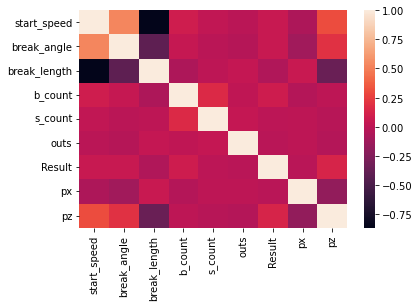

In [3]:
sns.heatmap(train.corr())
plt.show()

### VIF Analysis

VIF analysis showed all variables under multicollinearity threshold of 5, so there isn't a big concern for a collinearity problem. `start_speed` and `break_length` have the highest VIF values respectively.

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = train[['start_speed', 'break_angle','break_length','b_count','s_count','outs','px','pz']]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

vif_data

,feature,VIF
0,const,1296.068044
1,start_speed,4.759926
2,break_angle,1.437588
3,break_length,4.251973
4,b_count,1.033885
5,s_count,1.029418
6,outs,1.005690
7,px,1.045790
8,pz,1.186814


### Variable Distributions

- Density plots of each variable showed greatest difference in response for `px` and `pz`, and few visible differences in response for other numeric variables.
- `break_angle` and `break_length` have very similar distributions, so it's only necessary to keep one of them. Since the previous analysis revealed that `break_length` was highly correlated with `start_speed`, I decided to drop `break_length` and only keep `break_angle`.

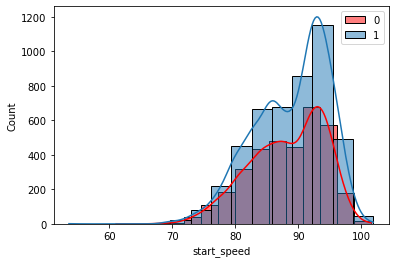

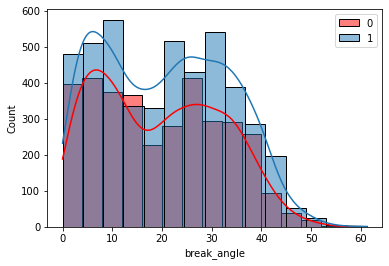

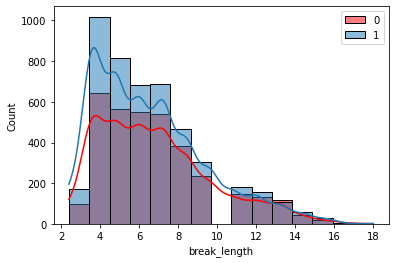

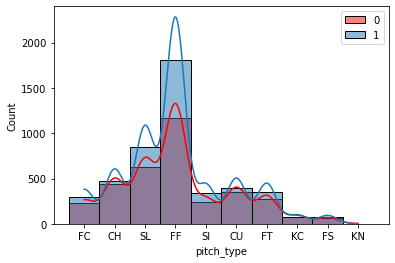

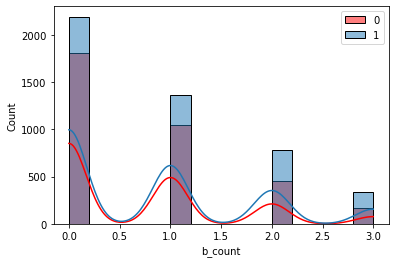

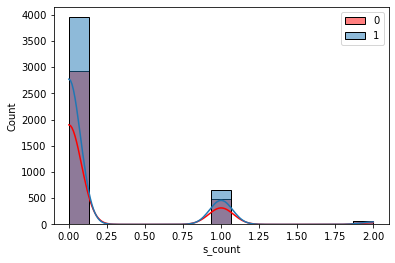

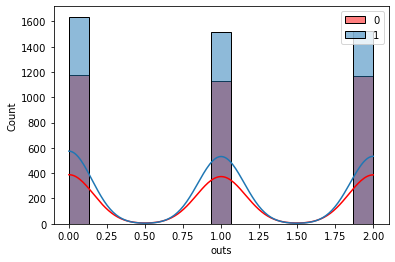

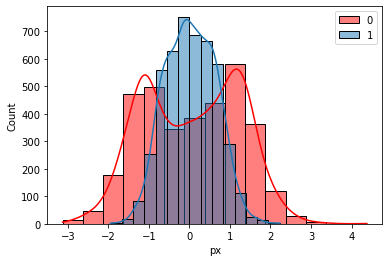

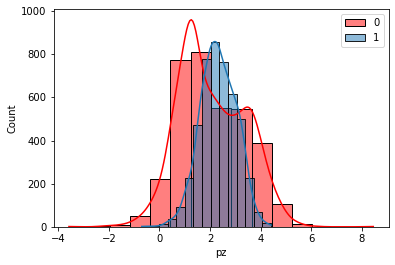

In [8]:
# Ignoring Result and code cols
plotdf = train.copy()
plotdf = plotdf.drop(['Result','code'], axis = 1)

for i in plotdf.columns:
    a_0 = train[train['Result'] == 0][i]
    a_1 = train[train['Result'] == 1][i]
    sns.histplot(a_0, kde = True, color = 'r',bins = 15, label = '0')
    sns.histplot(a_1, kde = True, bins = 15, label = '1')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    plt.show()

### Lineplots

The following lineplots were used to determine whether any of the continuous variables would benefit from transformations. Since `px` and `pz` do not increase monotonically, I decided to include a quadratic transformation on each of them.

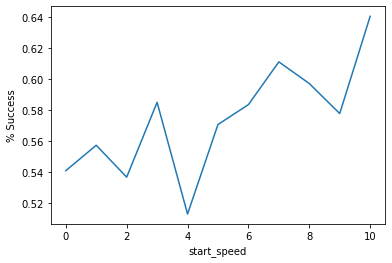

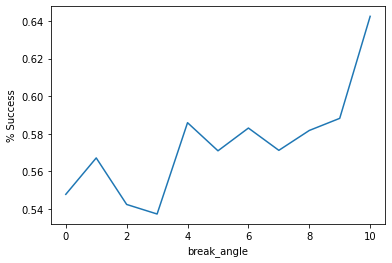

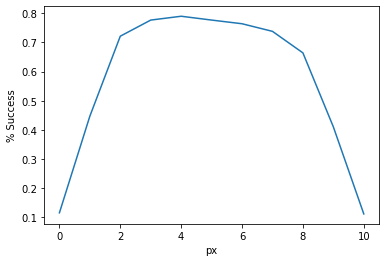

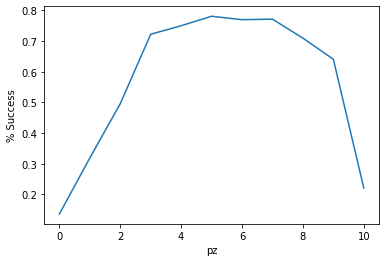

In [10]:
# Continuous variables
Z = train[['start_speed', 'break_angle','px','pz']]

# Binning variables and visualizing their lineplots against success percentage
for i in Z.columns:
    binned_var = pd.qcut(train[i],11,retbins=True)
    train['var_binned'] = binned_var[0]
    #Finding percentage of successful pitches in each bin
    var_data = train.groupby('var_binned')['Result'].agg([('% Success','mean'),('nobs','count')]).reset_index(drop=False)
    #Visualizing percentage of people having diabetes with increasing Age (or Age bins)
    sns.lineplot(x = var_data.index, y = var_data['% Success'])
    plt.xlabel(i)
    plt.show()

## Developing the model

### Code fitting the final model

- After lots of trial and error, the best model ended up including `s_count`, `b_count`, and singular and quadratic terms for both `px` and `pz`.
- This model gave all significant predictors, a significant LLR p-value, and a Pseudo R-squared of 0.42.

In [11]:
logit_model = sm.logit(formula = 'Result~px+pz+b_count+I(px**2)+I(pz**2)+s_count', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.395646
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Result   No. Observations:                 8147
Model:                          Logit   Df Residuals:                     8140
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.4201
Time:                        23:31:46   Log-Likelihood:                -3223.3
converged:                       True   LL-Null:                       -5558.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0158      0.196    -25.608      0.000      -5.400      -4.632
px             0.1145      0.039      2.931      0.003       0.038       0.191
pz             6.5409      0.188     34.791      0.000       6.172       6.909
b_count        0.1608      0.035      4.534      0.000       0.091       0.230
I(px ** 2)    -2.0492      0.055    -37.465      0.000      -2.156      -1.942
I(pz ** 2)    -1.3637      0.040    -34.392      0.000      -1.441      -1.286
s_count        0.4103      0.081      5.084      0.000       0.252       0.569
==============================================================================
"""

### Evaluating the final model

- Classification accuracy of 82.9%, recall of 89.6%, and AUC of 0.916 on train data
- Classification accuracy of 82.4% and recall of 89.6% on test data
- Test and train results are very comparable

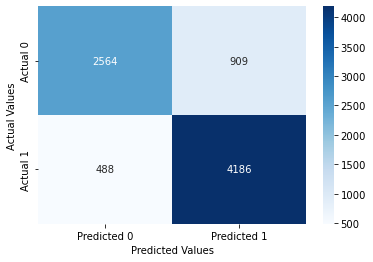

Classification accuracy = 82.9%
Precision = 82.2%
TPR or Recall = 89.6%
FNR = 10.4%
FPR = 26.2%


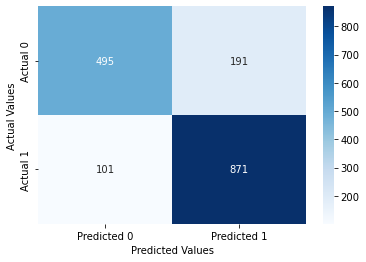

Classification accuracy = 82.4%
Precision = 82.0%
TPR or Recall = 89.6%
FNR = 10.4%
FPR = 27.8%
0.9163033898891886


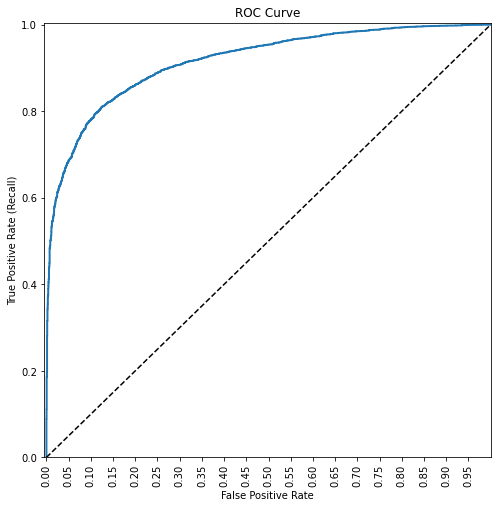

In [19]:
# Train accuracy and recall
confusion_matrix_data(train, train.Result, logit_model)

# Test accuracy and recall
confusion_matrix_data(test, test.Result, logit_model)

# AUC and ROC curve
from sklearn.metrics import roc_curve, auc

y=train.Result
ypred = logit_model.predict(train)

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr)) # AUC of ROC

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.show()

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

## Conclusions and Recommendations to stakeholders

Although the predictors we selected do not help much for in-game applications (since pitchers have little control over `px` and `pz`), there are still many takeaways for everyone in the baseball world that can take effect in practice and analytics scenarios.

- Coaches can make game-time decisions based on the proven track record of a given pitcher and the expected outcome of the next few pitches.
- Coaches can also hone in on what players are doing well or poorly in order to improve during practice.
- Pitchers can make informed decisions about what pitch to throw next based on ball and strike counts and attempt to control ball position as much as possible.
- Hitters can both make informed decisions about whether or not they should make an attempt to swing at a pitch based on ball and strike counts.
- Scouts and analysts can make objective decisions about a player's skill level of potential and identify what qualities they want in members of their pitching staff moving forward.